In [1]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm
from scipy.interpolate import griddata
from scipy.special import erf
from scipy.odr import ODR, Model, RealData

from astropy.coordinates import SkyCoord

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

import getdist
from getdist import plots, MCSamples

from loess.loess_2d import loess_2d

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from main_code.utils.constants import *
from main_code.utils.functions import *
from main_code.utils.CosmoFunc import *
from main_code.utils.filepaths import *

from scipy.stats import norm

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# Redshift consistency check

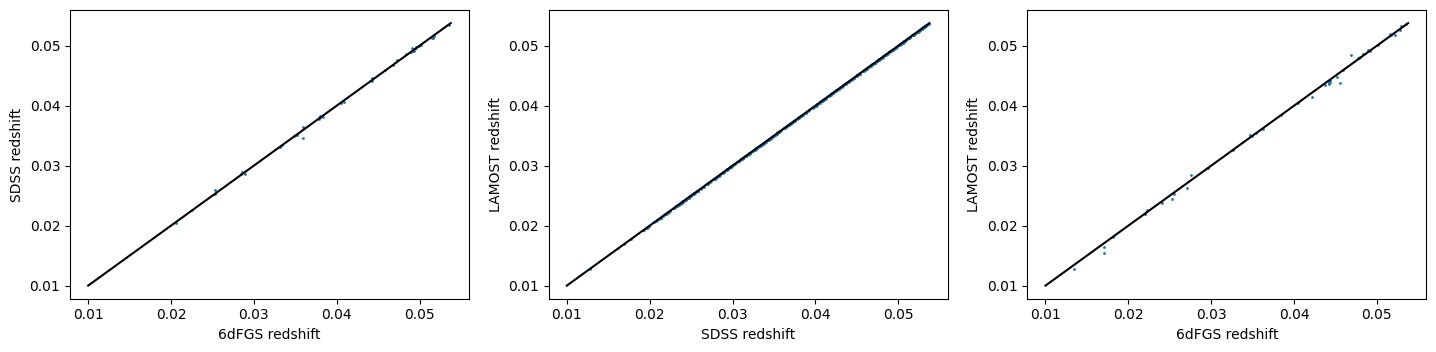

In [4]:
survey_combos = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
cols =['tmass', 'zhelio', 'z_cmb', 'z_dist_est']

figure_size = 5
fig, axs = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))
for i, combo in enumerate(survey_combos):
    survey1, survey2 = combo

    df1 = pd.read_csv(f"../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")[cols]

    df2 = pd.read_csv(f"../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")[cols]

    df = df1.merge(df2, on='tmass', how='inner', suffixes=(f'_{survey1.lower()}', f'_{survey2.lower()}'))

    # Plot
    ax = fig.axes[i]

    ax.scatter(df[f'z_dist_est_{survey1.lower()}'], df[f'z_dist_est_{survey2.lower()}'], s=1)
    ax.plot([ZMIN, ZMAX], [ZMIN, ZMAX], c='k')
    ax.set_xlabel(f'{survey1} redshift')
    ax.set_ylabel(f'{survey2} redshift')

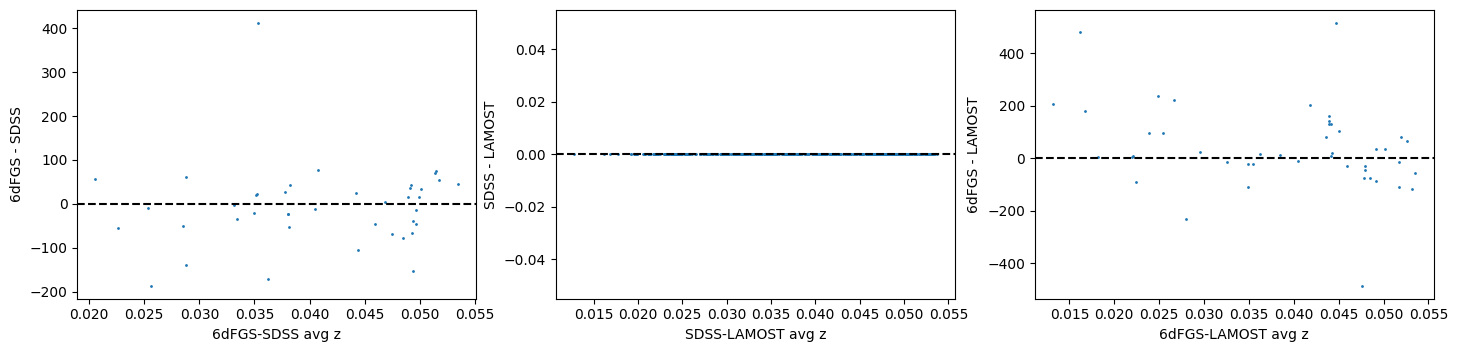

In [10]:
survey_combos = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
cols =['tmass', 'zhelio', 'z_cmb', 'z_dist_est']

z_col = 'z_dist_est'
figure_size = 5
fig, axs = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))
for i, combo in enumerate(survey_combos):
    survey1, survey2 = combo

    df1 = pd.read_csv(f"../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")[cols]

    df2 = pd.read_csv(f"../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")[cols]

    df = df1.merge(df2, on='tmass', how='inner', suffixes=(f'_{survey1.lower()}', f'_{survey2.lower()}'))
    df['delta_z'] = (df[f'{z_col}_{survey1.lower()}'] - df[f'{z_col}_{survey2.lower()}']) * LIGHTSPEED
    df['z_avg'] = 0.5 * (df[f'{z_col}_{survey1.lower()}'] + df[f'{z_col}_{survey2.lower()}'])

    # Plot
    ax = fig.axes[i]

    ax.scatter(df['z_avg'], df['delta_z'], s=1)
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlabel(f'{survey1}-{survey2} avg z')
    ax.set_ylabel(f'{survey1} - {survey2}')

# Pairwise error vs avg veldisp

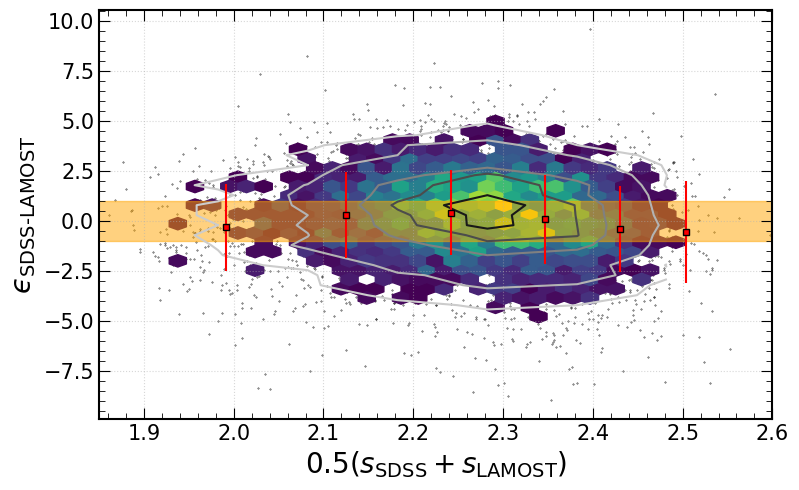

In [6]:
VELDISP_ORI_OUTPUT_FILEPATH = os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/repeat_ori.csv')

df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
df = df[~(df['s_sdss'].isna()) & ~(df['s_lamost'].isna())]

# Calculate epsilon
df['epsilon'] = (df['s_sdss'] - df['s_lamost']) / np.sqrt(df['es_sdss']**2 + df['es_lamost']**2)
df = df[np.absolute(df['epsilon']) < 10.]
# Calculate the average (to avoid correlated errors)
df['s_avg'] = 0.5 * (df['s_sdss'] + df['s_lamost'])

# Prepare the bins
S_BIN_WIDTH = 50.
# bin_list = np.log10(np.arange(10**df['s_avg'].min(), 10**df['s_avg'].max() + S_BIN_WIDTH, S_BIN_WIDTH))
bin_list = np.log10(np.array([1., 112., 150., 200., 250., 300., 500.]))
bin_label = range(1, len(bin_list))
df['s_bin'] = pd.cut(df['s_avg'], bin_list, labels=bin_label)

# Create the figure
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Create hexbin plot and bin coordinate and its corresponding value
ax.scatter(df['s_avg'], df['epsilon'], s=0.1, c='k')
h = ax.hexbin(df['s_avg'], df['epsilon'], gridsize=(40, 20), mincnt=5)
xy = h.get_offsets()
x = xy[:, 0]
y = xy[:, 1]
v = h.get_array()

xi=np.linspace(x.min(), x.max(), 25)
yi=np.linspace(y.min(), y.max(), 25)

# Create contour plot
X,Y= np.meshgrid(xi,yi)
Z = griddata((x, y), v, (X, Y), method='cubic')
# ax.contour(X, Y, Z, levels=[10, 15, 20, 22], cmap='gist_yarg', alpha=0.8)
cmap_ = plt.get_cmap("gray")
levels_plot = [(0.1, (0.1, 0.5), cmap_(0.1)), (0.25, (0.1, 0.5), cmap_(0.3)), (0.5, (0.1, 0.5), cmap_(0.5)), (0.75, (0.1, 0.5), cmap_(0.7)), (0.9, (0.1, 0.5), cmap_(0.8))]
density_contour(df['s_avg'], df['epsilon'], bins_levels_tuple_list=levels_plot, ax=ax)

# Create binned epsilon
df_grouped = df.groupby(['s_bin'], observed=False).agg(bin_count=('epsilon', 'count'), s_avg_mean=('s_avg', 'mean'), epsilon_mean=('epsilon', 'mean'), epsilon_std=('epsilon', 'std'))
df_grouped['mean_error'] = df_grouped['epsilon_std'] / np.sqrt(df_grouped['bin_count'])
ax.errorbar(x=df_grouped['s_avg_mean'], y=df_grouped['epsilon_mean'], yerr=df_grouped['epsilon_std'], marker='s', mfc='red',
         mec='k', ms=5, mew=1, ecolor='red', color='red', ls='none')

# Create horizontal line
# ax.axhline(y=0, color='k', ls='--')
# ax.axhline(y=1, color='k', ls=':')
# ax.axhline(y=-1, color='k', ls=':')
ax.fill_between(x=[1.8, 2.6], y1=[1.0, 1.0], y2=[-1.0, -1.0], alpha=0.5, color='orange')
ax.grid(ls=':', alpha=0.5)

# Labels and stuff
ax.set_xlabel(r'$0.5(s_\text{SDSS} + s_\text{LAMOST})$', fontsize=20)
ax.set_ylabel(r'$ϵ_\text{SDSS-LAMOST}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlim(1.85, 2.6)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.minorticks_on()
ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

# Save figure
fig.tight_layout()
# fig.savefig('../img/final_plot/fig_1_epsilon_vs_savg.pdf', bbox_inches='tight', dpi=300)

# Veldisp Pairwise Errors

Generating comparison plot with the following inputs:
Method: lamost_only
k_6df: 1
k_sdss: 1.71875
k_lamost: 1
off_6df: -0.023055306114635
off_sdss: 0.0
off_lamost: -0.0059398449947234

Comparison between 6df and sdss before scaling. Ngal = 6541...
- Mean of ϵ is -0.562 with standard error in the mean of 0.103. Therefore it is -5.448σ away from the expected 0.
- Std of ϵ is 0.661 with standard error in the std of 0.074. Therefore it is -4.595σ away from the expected 1.
Comparison between 6df and sdss after scaling. Ngal = 6541...
- Mean of ϵ is -0.151 with standard error in the mean of 0.102. Therefore it is -1.481σ away from the expected 0.
- Std of ϵ is 0.653 with standard error in the std of 0.073. Therefore it is -4.752σ away from the expected 1.

Comparison between sdss and lamost before scaling. Ngal = 6541...
- Mean of ϵ is 0.269 with standard error in the mean of 0.027. Therefore it is 9.791σ away from the expected 0.
- Std of ϵ is 2.21 with standard error in the std of 0.019. 

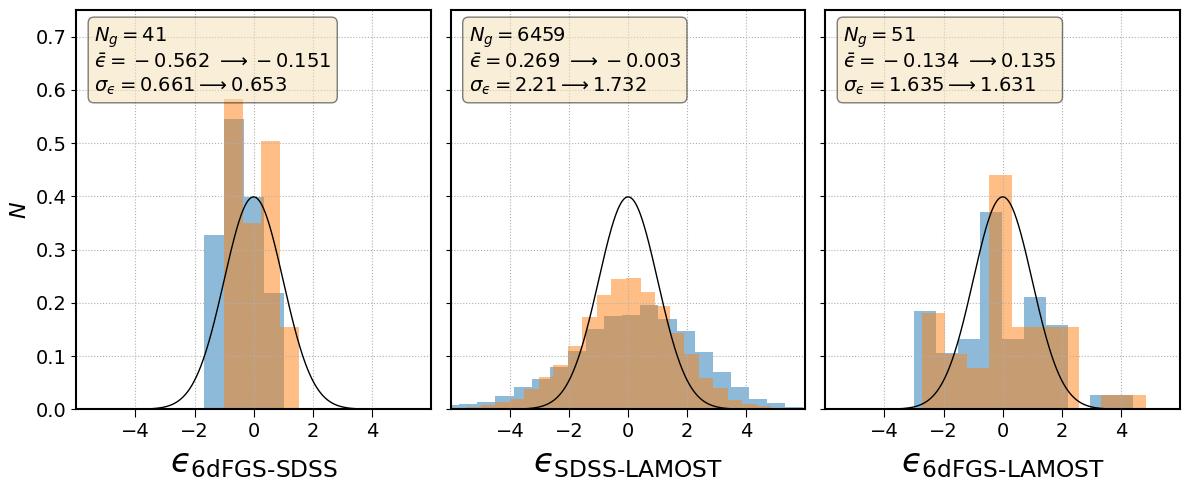

In [2]:
mpl.rcParams['axes.linewidth'] = 1.5

VELDISP_ORI_OUTPUT_FILEPATH = os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/repeat_ori.csv')

method = 'lamost_only'

off_6df, off_sdss, off_lamost = pd.read_csv('../artifacts/veldisp_calibration/totoffs.csv').loc[0].to_numpy()
k_6df, k_sdss, k_lamost = 1, 5.5/3.2, 1 # pd.read_csv(f'../artifacts/veldisp_calibration/scaling_sdss_lamost.csv')[['k_6df', 'k_sdss', 'k_lamost']].loc[0].to_numpy()

# CONSTANTS
BIN_LIST = [4, 40, 10]
XLIM_LIST = [(-6, 6), (-6, 6), (-6, 6)]
SURVEY_COMBOS = [('6df', 'sdss'), ('sdss', 'lamost'), ('6df', 'lamost')]
XLABEL_LIST = [r'$ϵ_\text{6dFGS-SDSS}$', r'$ϵ_\text{SDSS-LAMOST}$', r'$ϵ_\text{6dFGS-LAMOST}$']

print('Generating comparison plot with the following inputs:')
print(f'Method: {method}')
print(f'k_6df: {k_6df}')
print(f'k_sdss: {k_sdss}')
print(f'k_lamost: {k_lamost}')
print(f'off_6df: {off_6df}')
print(f'off_sdss: {off_sdss}')
print(f'off_lamost: {off_lamost}')
print()

df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
# off_6df = 0.
# off_sdss = 0.
# off_lamost = 0.
# Apply the offsets
df['s_6df_scaled'] = df['s_6df'] - off_6df
df['es_6df_scaled'] = df['es_6df'] * k_6df
df['s_sdss_scaled'] = df['s_sdss'] - off_sdss
df['es_sdss_scaled'] = df['es_sdss'] * k_sdss
df['s_lamost_scaled'] = df['s_lamost'] - off_lamost
df['es_lamost_scaled'] = df['es_lamost'] * k_lamost

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 5))

for i, combo in enumerate(SURVEY_COMBOS):
    survey_1, survey_2 = combo

    # Calculate original statistics
    epsilon = (df[f's_{survey_1}'] - df[f's_{survey_2}']) / np.sqrt(df[f'es_{survey_1}']**2 + df[f'es_{survey_2}']**2)
    Ngal = epsilon.notna().sum()
    # Calculate mean, std, and standard errors in them
    eps_mean = epsilon.median()
    eps_std = epsilon.std()
    eps_mean_stderr = eps_std / np.sqrt(Ngal)
    eps_std_stderr = eps_std / np.sqrt(2 * (Ngal - 1))
    mean_severity = eps_mean / eps_mean_stderr
    std_severity = (eps_std - 1.0) / eps_std_stderr

    print(f"Comparison between {survey_1} and {survey_2} before scaling. Ngal = {len(df)}...")
    print(f'- Mean of ϵ is {np.round(eps_mean, 3)} with standard error in the mean of {np.round(eps_mean_stderr, 3)}. Therefore it is {np.round(mean_severity, 3)}σ away from the expected 0.')
    print(f'- Std of ϵ is {np.round(eps_std, 3)} with standard error in the std of {np.round(eps_std_stderr, 3)}. Therefore it is {np.round(std_severity, 3)}σ away from the expected 1.')

    # Calculate statistics after scaling and offset
    epsilon_scaled = (df[f's_{survey_1}_scaled'] - df[f's_{survey_2}_scaled']) / np.sqrt(df[f'es_{survey_1}_scaled']**2 + df[f'es_{survey_2}_scaled']**2)
    Ngal_scaled = epsilon_scaled.notna().sum()
    # Calculate mean, std, and standard errors in them
    eps_scaled_mean = epsilon_scaled.median()
    eps_scaled_std = epsilon_scaled.std()
    eps_scaled_mean_stderr = eps_scaled_std / np.sqrt(Ngal_scaled)
    eps_scaled_std_stderr = eps_scaled_std / np.sqrt(2 * (Ngal_scaled - 1))
    scaled_mean_severity = eps_scaled_mean / eps_scaled_mean_stderr
    scaled_std_severity = (eps_scaled_std - 1.0) / eps_scaled_std_stderr

    print(f"Comparison between {survey_1} and {survey_2} after scaling. Ngal = {len(df)}...")
    print(f'- Mean of ϵ is {np.round(eps_scaled_mean, 3)} with standard error in the mean of {np.round(eps_scaled_mean_stderr, 3)}. Therefore it is {np.round(scaled_mean_severity, 3)}σ away from the expected 0.')
    print(f'- Std of ϵ is {np.round(eps_scaled_std, 3)} with standard error in the std of {np.round(eps_scaled_std_stderr, 3)}. Therefore it is {np.round(scaled_std_severity, 3)}σ away from the expected 1.')

    axs[i].hist(epsilon, bins=BIN_LIST[i], density=True, alpha=0.5)
    axs[i].hist(epsilon_scaled, bins=BIN_LIST[i], density=True, alpha=0.5)

    # Write the before and after statistics
    textstr = '\n'.join((
        fr'$N_g = {Ngal}$',
        r'$\bar{ϵ}=%.3f$' % eps_mean + fr' $\longrightarrow {np.round(eps_scaled_mean, 3)}$',
        fr'$\sigma_ϵ={np.round(eps_std, 3)} \longrightarrow {np.round(eps_scaled_std, 3)}$'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[i].text(-5.4, 0.72, textstr, fontsize=14,
            verticalalignment='top', bbox=props)

    # Misc
    axs[i].grid(linestyle=":")
    axs[i].set_xlim(XLIM_LIST[i])
    axs[i].set_ylim(0., 0.75)
    axs[i].set_xlabel(XLABEL_LIST[i], fontsize=24)
    axs[i].set_xticks(axs[i].get_xticks()[1:-1])
    axs[0].set_ylabel(r'$N$', fontsize=16)
    
    print()

# Plot standard normal Gaussians (target)
x = np.arange(start=-10., stop=10., step=0.0001)
y = norm.pdf(x, loc=0., scale=1.)
for ax in axs:
    ax.plot(x, y, c='k', lw=1.0)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', which='major', length=6)

plt.subplots_adjust(wspace=0)

plt.tight_layout()
# fig.savefig('../img/final_plot/veldisp_comparison.pdf', bbox_inches='tight', dpi=300)

In [3]:
1.732 * 5.5/3.2

2.9768749999999997

# Veldisp error distribution before vs after for SDSS & LAMOST

In [141]:
# bins = np.linspace(0, 51, 60)

# k_6df, k_sdss, k_lamost = pd.read_csv(f'../artifacts/veldisp_calibration/scaling_sdss_lamost.csv')[['k_6df', 'k_sdss', 'k_lamost']].loc[0].to_numpy()

# colors = ['C0', 'C1', 'C2']

# fig, ax = plt.subplots(figsize=(DEFAULT_FIGSIZE[0], DEFAULT_FIGSIZE[1] * 0.75))
# for i, survey in enumerate(SURVEY_LIST):
#     df = pd.read_csv(f"../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
#     df['es_pct'] = df['es'] * np.log(10) * 100
#     xdata = df['es_pct'].to_numpy()

#     print(xdata.max())

#     y, x_edges = np.histogram(xdata, bins=bins, density=True)
#     ymax = y.max()

#     ax.hist(xdata, bins=bins, histtype='step', color=colors[i], label=survey)

#     if survey in ['SDSS', 'LAMOST']:
#         ax.hist(df['es_pct'] / k_sdss, bins=bins, histtype='step', ls='--', color=colors[i])

#     ax.set_xscale('log')

#     # Labels
#     ax.legend(fontsize=12)
#     ax.set_xlabel(r"$\Delta\sigma/\sigma$ (%)", fontsize=18)
#     ax.set_ylabel(r"$N$", fontsize=14)
#     ax.tick_params(axis='x', labelsize=12, direction="out")
#     ax.tick_params(axis='x', which='major', length=6)

# # fig.savefig('../img/final_plot/veldisp_err_distribution.pdf', bbox_inches='tight', dpi=300)

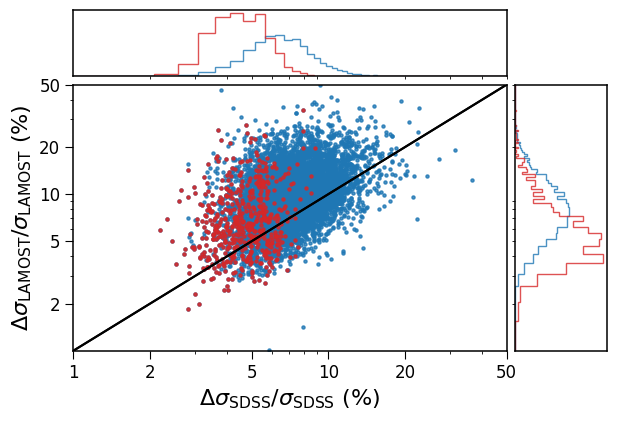

In [165]:
mpl.rcParams['axes.linewidth'] = 1.1

labels = [2, 5, 10, 20, 50]
colors = ['C0', 'C3']
bins = np.linspace(0, 51, 100)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 4), height_ratios=[1.0, 4], width_ratios=[3.5, 0.75])
fig.axes[1].remove()
fig.tight_layout(w_pad=-2.5, h_pad=-1.5)

for i, filepath in enumerate([
    "../data/processed/veldisp_calibrated/",
    "../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/",
]):
    if i == 1:
        veldisp_err_col = 'es'
    else:
        veldisp_err_col = 'es_scaled'

    df1 = pd.read_csv(filepath + "sdss.csv")[['tmass', veldisp_err_col]]
    df1['es'] = df1[veldisp_err_col] * np.log(10) * 100

    df2 = pd.read_csv(filepath + "lamost.csv")[['tmass', veldisp_err_col]]
    df2['es'] = df2[veldisp_err_col] * np.log(10) * 100

    df = df1.merge(df2, on='tmass', suffixes=('_sdss', '_lamost'))

    # Ax1: big axis (es_sdss vs es_lamost)
    ax = fig.axes[1]
    ax.scatter(df['es_sdss'], df['es_lamost'], s=5, c=colors[i], alpha=0.8, rasterized=True)
    ax.plot([1, 50], [1, 50], c='k')

    ax.set_xlabel(r"$\Delta\sigma_\mathrm{SDSS}/\sigma_\mathrm{SDSS}$ (%)", fontsize=16)
    ax.set_ylabel(r"$\Delta\sigma_\mathrm{LAMOST}/\sigma_\mathrm{LAMOST}$ (%)", fontsize=16)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xticks([1] + labels)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_yticks(labels)
    ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.set_xlim(1, 50)
    ax.set_ylim(1, 50)

    ax.tick_params(axis='both', labelsize=12, direction="out")
    ax.tick_params(axis='both', which='major', length=6)


    # Ax0: histogram of SDSS relative error
    ax = fig.axes[0]
    ax.hist(df['es_sdss'], bins=bins, color=colors[i], alpha=0.8, histtype='step', density=True)
    ax.set_xscale('log')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlim(1, 50)


    # Ax2: histogram of LAMOST relative error
    ax = fig.axes[2]
    ax.hist(df['es_lamost'], bins=bins, color=colors[i], alpha=0.8, histtype='step', orientation='horizontal', density=True)
    ax.set_yscale('log')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_ylim(1, 50)

fig.savefig('../img/final_plot/veldisp_err_distribution.pdf', bbox_inches='tight', dpi=300)

# Redshift, Magnitude, and FP observables distributions

6dFGS | 6217
SDSS | 4418
LAMOST | 2140


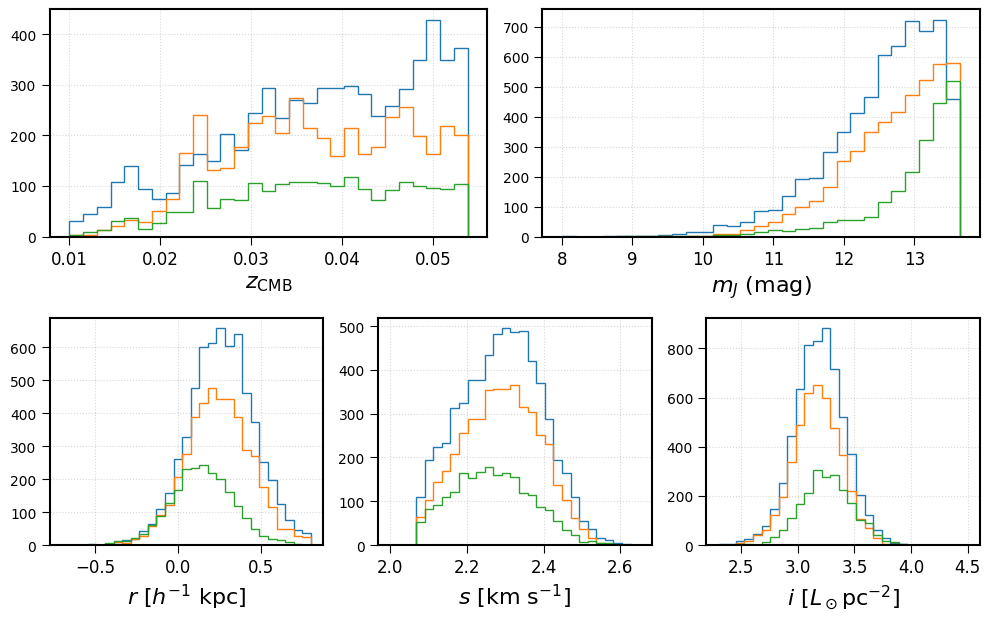

In [156]:
mpl.rcParams['axes.linewidth'] = 1.5

# Create a figure
fig = plt.figure(figsize=(10, 18))

# Create a GridSpec with 3 rows and 3 columns
gs = gridspec.GridSpec(6, 6, figure=fig)

# First row, two equal sized columns
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:])
# Second row, three equal sized columns
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# Column names and labels
cols = ['z_dist_est', 'mag_j', 'r', 's', 'i']
col_labels = [r'$z_\mathrm{CMB}$', r'$m_J$ (mag)', r'$r$ [$h^{-1}$ kpc]', r'$s$ [km s$^{-1}$]', r'$i\ [L_\odot \mathrm{pc}^{-2}]$']

# Number of bins
N_BINS = 30

# Define the bins
hist_bins = {
    "z_dist_est": np.linspace(ZMIN, ZMAX, N_BINS), # redshift bins
    "mag_j": np.linspace(MAG_LOW, MAG_HIGH, N_BINS), # magnitude bins
    "r": np.linspace(-0.7, 0.8, N_BINS), # radius bins
    "s": np.linspace(2.0, 2.65, N_BINS), # veldisp bins
    "i": np.linspace(2.3, 4.5, N_BINS) # intensity bins
}

for survey in SURVEY_LIST:
    df = pd.read_csv(f'../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv')
    print(survey, '|', len(df))
    df['mag_j'] = df['j_m_ext'] - df['extinction_j']

    for i, col in enumerate(cols):
        ax = fig.axes[i]
        ax.hist(df[col], bins=hist_bins.get(col), histtype='step')
        ax.set_xlabel(col_labels[i], fontsize=16)

for ax in fig.axes:
    ax.grid(ls=':', alpha=0.5)
    ax.tick_params(axis='x', labelsize=12, direction="out")
    ax.tick_params(axis='both', which='major', length=6)

# Adjust layout to make it look nice
fig.tight_layout()
fig.savefig('../img/final_plot/fp_distributions.pdf', bbox_inches='tight', dpi=300)

# Photometric Error Model

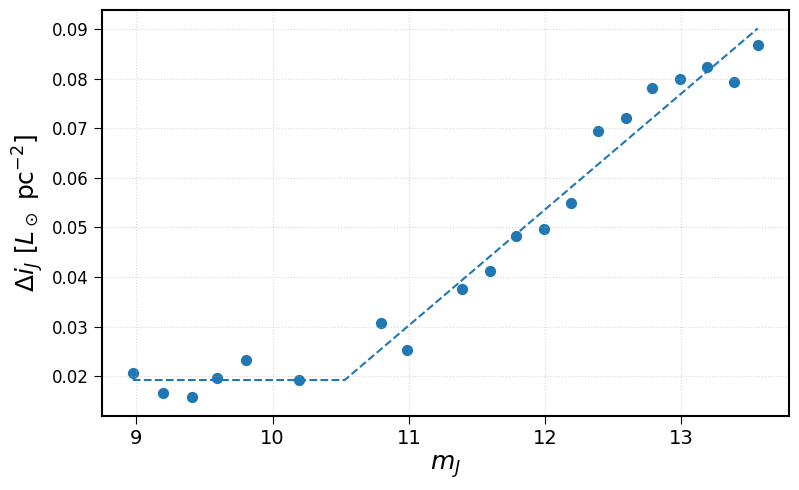

In [162]:
mpl.rcParams['axes.linewidth'] = 1.5

def piecewise_linear(x: np.ndarray, x0: float, y0: float, k: float) -> np.ndarray:
    '''
    A function that is constant at x <= x0, and linear at x > x0.
    '''
    y_pred = np.piecewise(x, [x <= x0, x > x0], [lambda x: y0, lambda x: k * (x - x0) + y0])
    return y_pred

# Load the model
popt = pd.read_csv('../artifacts/phot_error/smin_setting_1/model.csv').to_numpy()[0]

# Load the data
x_data = np.load('../artifacts/phot_error/smin_setting_1/xdata.npy')
y_data = np.load('../artifacts/phot_error/smin_setting_1/ydata.npy')

# Load trial x and y
x_trial = np.linspace(np.min(x_data), np.max(x_data), 1000)
y_trial = piecewise_linear(x_trial, *popt)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

ax.scatter(x_data, y_data, s=50, rasterized=True)
ax.plot(x_trial, y_trial, ls='--')
ax.set_xlabel(r'$m_J$', fontsize=18)
ax.set_ylabel(r'$\Delta i_J\ [L_\odot\ \mathrm{pc}^{-2}]$', fontsize=18)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(ls=':', alpha=0.5)

ax.tick_params(axis='x', labelsize=14, direction="out")
ax.tick_params(axis='both', which='major', length=6)

fig.tight_layout()
fig.savefig('../img/final_plot/phot_errors.pdf', bbox_inches='tight', dpi=300)